In [1]:
using Primes
using PyPlot
using BenchmarkTools
BenchmarkTools.DEFAULT_PARAMETERS.samples = 50

50

In [2]:
function initialize(n, pₙ)
    d = primes(pₙ)
    Aₙ = spdiagm(d, 0)
    e = ones(n, 1)

    for k in 2.^( 0:floor(Int,log2(n)))
        eₖ = e[1:(n-k)]
        Aₙ = Aₙ + spdiagm( [eₖ,eₖ], [-k k])       
    end
    
    Aₙ
end

n = 2000 #20000
pₙ = 17389 #224737

Aₙ = initialize(n, pₙ)
b = zeros(n); b[1] = 1;

In [3]:
# Bounded Insertion sort
# This is actually a copy paste of https://github.com/JuliaLang/julia/blob/v0.5.1/base/sort.jl#L218
# but I couldn't find how to actually call this function 
function bounded_insertion_sort!(v::AbstractVector, lo::Int, hi::Int, by=identity)
    @inbounds for i = lo+1:hi
        j = i
        x = v[i]
        while j > lo
            if by(x) < by(v[j-1])
                v[j] = v[j-1]
                j -= 1
                continue
            end
            break
        end
        v[j] = x
    end
    return v
end

bounded_insertion_sort! (generic function with 2 methods)

In [4]:
function sort_inverse(p)
    out = [ i for i in 1:length(p) ]
    @inbounds for i = 1:length(p)
        out[p[i]] = i
    end
    out
end

# Reverse Cuthill McKee
function rcm(A::SparseMatrixCSC)
    n = size(A, 1)
    x₀ = 0
    
    # bookkeeping on the nodes to know which ones have to be enqueued
    visited = falses(n)
    touched = falses(n)
    
    # pre compute the degree of each node in the graph
    degrees = [0 for i in 1:n]
    @inbounds for i=1:n
        # see internal representation of CSR
        degrees[i] = Aₙ.colptr[i+1] - Aₙ.colptr[i]
    end
    
    # pre-compute the degree ordering
    sorted = sortperm(degrees)
    sorted_inv = sort_inverse(sorted)
    
    # the queue will contain the resulting permutation as well as the
    # next nodes to process withing queue[queue_start : queue_end]
    queue = [0 for i in 1:n]
    queue_start = 1
    queue_end = 1

    while queue_start < n
        # here the queue is empty, we look for the leastconnected node that was not visited
        # so far to repopulate the queue
        @inbounds for i = 1:n
            if !visited[i]
                x₀ = sorted[sorted_inv[i]] 
                break
            end
        end
        
        # enqueue x₀
        touched[x₀] = true
        queue[queue_end] = x₀
        queue_end += 1
        
        # process the queue
        while queue_start < queue_end
            # pop out one element
            x = queue[queue_start]
            visited[x] = true
            queue_start += 1
            
            # add the nodes adjacent to the current node to the queue, ignoring node
            # that were already queued
            adj_len = 0

            # iterate over the non-zero elements of the x column
            @inbounds for i = Aₙ.rowval[Aₙ.colptr[x]:(Aₙ.colptr[x+1]-1)]
                if !touched[i]
                    queue[queue_end + adj_len] = i
                    touched[i] = true
                    adj_len += 1
                end
            end
            
            if adj_len == 0
                continue
            end
            
            # sort the nodes we've just added to the queue and finish the growing process by moving queue_end
            bounded_insertion_sort!(queue, queue_end, queue_end + adj_len - 1, adj -> sorted_inv[adj])   
            queue_end += adj_len
        end
    end
    
    reverse(queue)
end

rcm (generic function with 1 method)

In [5]:
function solve_chol_RCM(Aₙ,b) 
    p = rcm(Aₙ)
    F = cholfact(Aₙ, perm = p)
    x = F\b
    return x[1]
end

solve_chol_RCM (generic function with 1 method)

In [7]:
@time p = rcm(Aₙ)
@time F = cholfact(Aₙ, perm = p)
@time x = F\b;

x[1]

  0.010812 seconds (98.75 k allocations: 2.702 MB)
  0.336887 seconds (62 allocations: 12.594 MB)
  0.001722 seconds (16 allocations: 69.031 KB)


0.7250188326252592

In [23]:
using Base.SparseArrays.CHOLMOD
@edit solve(CHOLMOD_A, F, convert(Dense{Float64}, b))

LoadError: UndefVarError: solve not defined

Permuted Matrix AₙNon zero entries: 

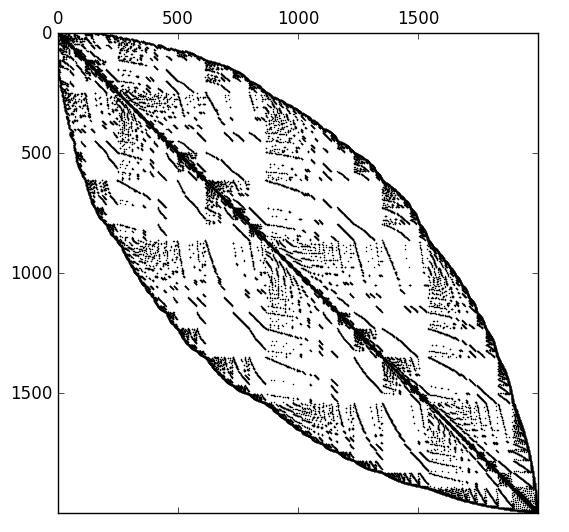

1.04765%

In [8]:
print("Permuted Matrix Aₙ")
spy(Aₙ[p,p], markersize = 0.5) 

print("Non zero entries: ", nnz(Aₙ)/length(full(Aₙ))*100, "%") 

L-Matrix of the Cholesky FactorisationDensity of the lower half: 

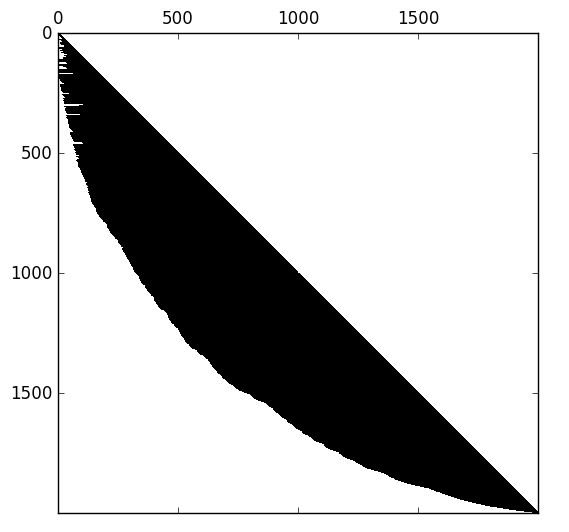

54.079449999999994 %

PyObject <matplotlib.image.AxesImage object at 0x7fe921f1bf10>

In [26]:
print("L-Matrix of the Cholesky Factorisation")
print("Density of the lower half: ", 2*nnz(L)/length(full(L))*100, " %");

L = sparse(F[:L])
spy(L);


### Why is it faster

We must admit that the reason why this factorization leads to better performances was a bit of a mystery. How can a sparse matrix with a higher fill-in ratio performs better?

The reason for this lies in the implementation of the solver. The cholesky factorisation was done using the supernodal method. The supernodal method will perform the solving of the equation by solving several dense matrix equations.

Thus, even if the RCM permutation will result in more fill-in, it will reduce the spreading of the non zero elements, bringing them all close to the diagonal. This allows to use a smaller number of denser dense matrices to be solved by blas, resulting in less operations to be made!

Without going in too many further details (https://github.com/PetterS/SuiteSparse/blob/27e5a8516464a6ac40bd3fa0e5b46e51b11f4765/CHOLMOD/Supernodal/t_cholmod_super_solve.c#L17 and https://www.researchgate.net/publication/220492578_Algorithm_887_CHOLMOD_Supernodal_Sparse_Cholesky_Factorization_and_UpdateDowndate)
we see in the next block that only 29 iterations (supernodes) are needed here and that the L\_1 matrices have a total of 117k elements against 231 iterations (supernodes) and 1.8M elements for AMD.


#### TODO: more details on the supernodes

https://github.com/PetterS/SuiteSparse/blob/master/CHOLMOD/Cholesky/cholmod_solve.c#L948
https://github.com/PetterS/SuiteSparse/blob/27e5a8516464a6ac40bd3fa0e5b46e51b11f4765/CHOLMOD/Supernodal/cholmod_super_solve.c#L45
https://github.com/PetterS/SuiteSparse/blob/27e5a8516464a6ac40bd3fa0e5b46e51b11f4765/CHOLMOD/Supernodal/t_cholmod_super_solve.c#L17

In [91]:
c = unsafe_load(F.p)
s = 0
for i = 1:c.nsuper
    k1 = unsafe_load(c.super, i)
    k2 = unsafe_load(c.super, i+1)
    psi = unsafe_load(c.pi, i)
    psend = unsafe_load(c.pi, i+1)
    nsrow = psend - psi
    nscol = k2 - k1
    s += nsrow * nscol
end
println(c.nsuper, " ",  s)

29 1172064
